In [95]:
import SimpleITK as sitk
import numpy as np
import csv
import os
import matplotlib.pyplot as plt
%matplotlib inline 
from PIL import Image
from sklearn.cluster import KMeans
from skimage.morphology import binary_erosion, binary_dilation, binary_opening, binary_closing
from skimage.measure import regionprops, label
import re
import pandas as pd
from tempfile import TemporaryFile

In [96]:
'''
Partitions the folder downloaded into smaller ones, which is easier to handle.
EX: ~/.../subset0/img.mhd -> ~/.../subset0/0/img.mhd
n_files: max number of files in a folder (the /0/ maximum)
'''

def split_dir(d, n_files = 8):
    lst_files = []
    file_c = 0
    c = 0
    new_dir = d
    for file in os.listdir(d):
        if re.search('.mhd$', file) or re.search('.raw$', file):
            lst_files.append(file)
    for file in sorted(lst_files):
        if c == 2 * n_files or file_c == 0: # EVEN to group the .raw and .mhd files in same directory
            new_dir = d + str(file_c) + '/'
            os.makedirs(new_dir, 0o755, exist_ok = True)
            c = 0
            file_c += 1
        os.rename(d + file, new_dir + file)
        c += 1

In [97]:
split_dir('/Users/kanetian7/LUNA16/data/subset0/')

In [98]:
'''
Initial processing functions.
'''

# load in SimpleITK .mhd file as numpy array
def load_img(filename):
    itkimage = sitk.ReadImage(filename)
    numpy_image = sitk.GetArrayFromImage(itkimage) # z, y, x...
    numpy_origin = np.array(itkimage.GetOrigin()) # x, y, z...
    numpy_spacing = np.array(itkimage.GetSpacing())
    return numpy_image, numpy_origin, numpy_spacing

# normalize image
def normalize(img):
    mean = np.mean(img)
    std = np.std(img)
    return (img - mean)/std

# show distribution of intensity
def distribution(normalize_img):
    plt.hist(normalize_img.flatten(), bins = 200)
    plt.show()

In [112]:
'''
Convert norm_img to an image (numpy array) with only 1s and 0s.
1s = initial lungs regions + noise
0s = background/non-lung tissue + noise
PRECONDITION: norm_img is a normalized numpy array
'''

def convert_binary(norm_img):
    # move outliers of images with the extra background circle to 
    # intensity that won't affect kmeans significantly
    minimum = np.min(norm_img)
    norm_img[norm_img == minimum] = np.median(norm_img)
    
    print('Kmeans is doing its thing')
    # empirical values but haven't really tested thoroughly, kmeans takes too long
    kmeans = KMeans(n_clusters = 2, random_state = 0, n_init = 1, max_iter = 1).fit(norm_img.flatten().reshape(-1, 1))
    print('Kmeans is done')
    
    # convert image to 1s and 0s based on threshold
    centers = np.sort(kmeans.cluster_centers_.flatten())
    thresh = (centers[0] + centers[1]) / 2
    bin_img = np.where(norm_img < thresh, 1.0, 0.0)
    return bin_img  

In [113]:
'''
Removes noise regions from bin_img through erosion and then dilation. 
PRECONDITION: bin_img is binary numpy array
'''

def make_regions(bin_img):
    for s in range(bin_img.shape[0]):
        s1 = bin_img[s,:,:]
        s2 = binary_erosion(s1, selem = np.ones([2, 2]))  # empirically determined
        bin_img[s,:,:] = binary_dilation(s2, selem = np.ones([8, 8])) # empirically determined
    return bin_img

In [114]:
'''
Isolates the lung regions and makes a binary mask over them.
1s = lung regions
0s = non-lung regions
PRECONDITION: reg_img is a non-noisy binary image
'''

def make_mask(reg_img):
    mask = np.zeros(reg_img.shape)
    for s in range(reg_img.shape[0]):
        # a slice in the 3D reg_img
        s1 = reg_img[s,:,:]
        props = regionprops(label(s1))
        labels = []
        for p in props:
            B = p.bbox
            # empirically determined, region has to be within confines and large enough
            if (B[0] > 10 and B[2] < 500 and B[1] > 10 and 
                B[3] < 500 and B[2] - B[0] > 50 and B[3] - B[1] > 50):
                labels.append(p.label)
        for l in labels:
            mask[s, :, :] = mask[s, :, :] + np.where(label(s1) == l, 1, 0)
    return mask

# m = make_mask(x)

In [115]:
'''
Applies the mask to the original, non-normalized image. 
Renormalizes using significant regions only, which is desired.
PRECONDITION: mask is original's corresponding mask
'''

def mask_on_orig(original, mask):
    new_img = original * mask
    
    mean = np.mean(original[mask > 0])
    std = np.std(original[mask > 0])
    new_img = (new_img - mean)/std
    # set non-lung regions to -5, which is logical since it's highly unlikely to interfere
    new_img[mask==0] = -5 
    return new_img

In [116]:
'''
Uses previous methods to process through a whole image.
Returns the masked image and (origin and spacing) from SimpleITK
'''

def process_img(filename):
    img, origin, spacing = load_img(filename)
    norm_img = normalize(img)
    bin_img = convert_binary(norm_img)
    reg_img = make_regions(bin_img)
    mask = make_mask(reg_img)
    masked_img = mask_on_orig(img, mask)
    
    return masked_img, origin, spacing

In [117]:
'''
Processes all LUNA files in a directory:
    - creates a new directory on the same level as the directory of images
    - uses process_img to get the masked image, origin, spacing for each image
    - stores the masked image array into a text file in the new directory
    - stores the origin, spacing coordinates, size of array into a csv file in out_meta
'''

def process_dir(d, out_dir, out_meta = '/Users/kanetian7/LUNA16/data/meta.csv'):
    os.makedirs(out_dir, 0o755, exist_ok = True)
    
    originsZ = []
    originsY = []
    originsX = []
    spacingsZ = []
    spacingsY = []
    spacingsX = []
    names = []
    zDim = []
    yDim = []
    xDim = []
    df = pd.read_csv(out_meta)
    
    for file in os.listdir(d):
        if re.search('.mhd$', file):
            print(file + ' is processing')
            img, origin, spacing = process_img(d + file)
            img.tofile(out_dir + 'p_' + re.split('.mhd$', file)[0] + '.txt', sep = ',')
            
            originsZ.append(origin[2])
            originsY.append(origin[1])
            originsX.append(origin[0])
            spacingsZ.append(spacing[2])
            spacingsY.append(spacing[1])
            spacingsX.append(spacing[0])
            zDim.append(img.shape[0])
            yDim.append(img.shape[1])
            xDim.append(img.shape[2])
            names.append(re.split('.mhd$', file)[0])
            # visualize a slice to make sure mask is generated correctly
            plt.imshow(img[int(0.5 * img.shape[0]), 0:512, 0:512])
            plt.show()
            print(file + ' is done')
            
    new = pd.DataFrame({'Name': names, 'OriginZ': originsZ, 'OriginY': originsY, 'OriginX': originsX,
                        'SpacingZ': spacingsZ, 'SpacingY': spacingsY, 'SpacingX': spacingsX, 
                        'zDim': zDim, 'yDim': yDim, 'xDim': xDim})
    df = pd.concat([df, new], axis = 0).reset_index(drop=True)
    df.to_csv(out_meta)

1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565.mhd is processing
kmeans is starting
kmeans is done


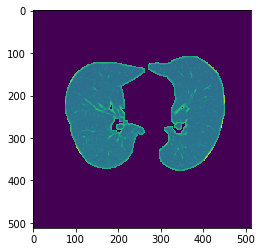

1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565.mhd is done
1.3.6.1.4.1.14519.5.2.1.6279.6001.126264578931778258890371755354.mhd is processing
kmeans is starting
kmeans is done


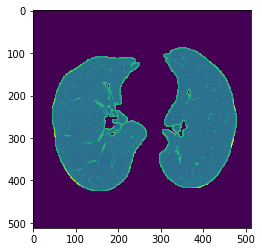

1.3.6.1.4.1.14519.5.2.1.6279.6001.126264578931778258890371755354.mhd is done
1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.mhd is processing
kmeans is starting
kmeans is done


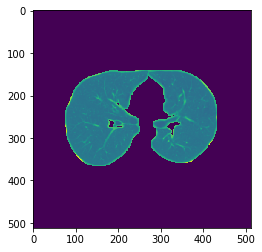

1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.mhd is done
1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.mhd is processing
kmeans is starting
kmeans is done


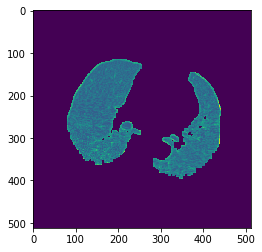

1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.mhd is done
1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896761494371822656720.mhd is processing
kmeans is starting
kmeans is done


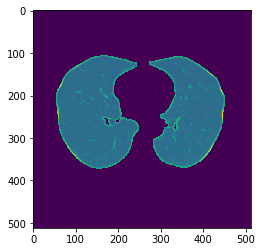

1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896761494371822656720.mhd is done
1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd is processing
kmeans is starting
kmeans is done


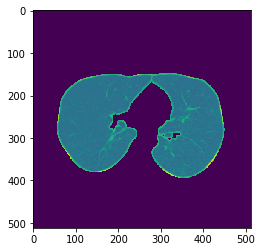

1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd is done
1.3.6.1.4.1.14519.5.2.1.6279.6001.126121460017257137098781143514.mhd is processing
kmeans is starting
kmeans is done


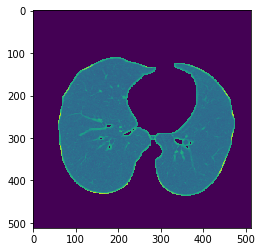

1.3.6.1.4.1.14519.5.2.1.6279.6001.126121460017257137098781143514.mhd is done
1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987.mhd is processing
kmeans is starting
kmeans is done


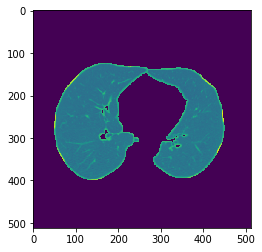

1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987.mhd is done


In [111]:
process_dir('/Users/kanetian7/LUNA16/data/subset0/0/', '/Users/kanetian7/LUNA16/data/processed0/')

1.3.6.1.4.1.14519.5.2.1.6279.6001.129055977637338639741695800950.mhd is processing
Kmeans is doing its thing
Kmeans is done


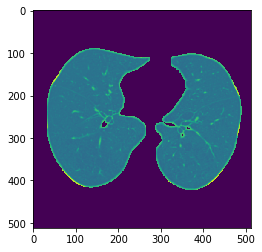

1.3.6.1.4.1.14519.5.2.1.6279.6001.129055977637338639741695800950.mhd is done
1.3.6.1.4.1.14519.5.2.1.6279.6001.137763212752154081977261297097.mhd is processing
Kmeans is doing its thing
Kmeans is done


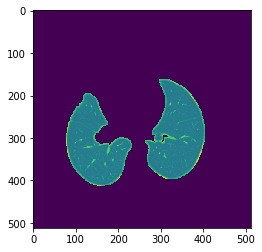

1.3.6.1.4.1.14519.5.2.1.6279.6001.137763212752154081977261297097.mhd is done
1.3.6.1.4.1.14519.5.2.1.6279.6001.139258777898746693365877042411.mhd is processing
Kmeans is doing its thing
Kmeans is done


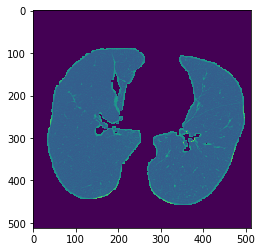

1.3.6.1.4.1.14519.5.2.1.6279.6001.139258777898746693365877042411.mhd is done
1.3.6.1.4.1.14519.5.2.1.6279.6001.138080888843357047811238713686.mhd is processing
Kmeans is doing its thing
Kmeans is done


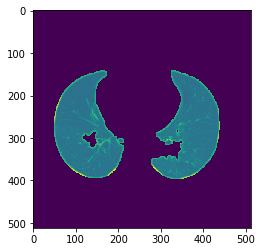

1.3.6.1.4.1.14519.5.2.1.6279.6001.138080888843357047811238713686.mhd is done
1.3.6.1.4.1.14519.5.2.1.6279.6001.134996872583497382954024478441.mhd is processing
Kmeans is doing its thing
Kmeans is done


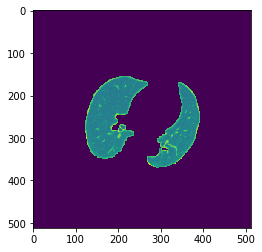

1.3.6.1.4.1.14519.5.2.1.6279.6001.134996872583497382954024478441.mhd is done
1.3.6.1.4.1.14519.5.2.1.6279.6001.130438550890816550994739120843.mhd is processing
Kmeans is doing its thing
Kmeans is done


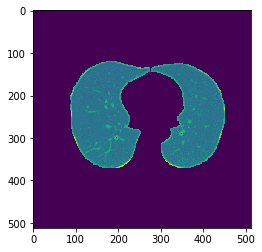

1.3.6.1.4.1.14519.5.2.1.6279.6001.130438550890816550994739120843.mhd is done
1.3.6.1.4.1.14519.5.2.1.6279.6001.128023902651233986592378348912.mhd is processing
Kmeans is doing its thing
Kmeans is done


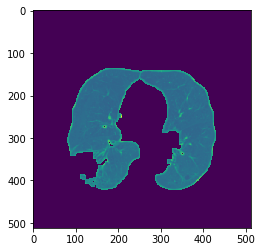

1.3.6.1.4.1.14519.5.2.1.6279.6001.128023902651233986592378348912.mhd is done
1.3.6.1.4.1.14519.5.2.1.6279.6001.139713436241461669335487719526.mhd is processing
Kmeans is doing its thing
Kmeans is done


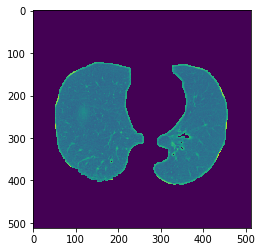

1.3.6.1.4.1.14519.5.2.1.6279.6001.139713436241461669335487719526.mhd is done


In [118]:
process_dir('/Users/kanetian7/LUNA16/data/subset0/1/', '/Users/kanetian7/LUNA16/data/processed0/')

1.3.6.1.4.1.14519.5.2.1.6279.6001.194440094986948071643661798326.mhd is processing
Kmeans is doing its thing
Kmeans is done


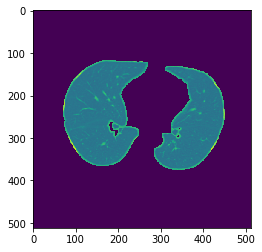

1.3.6.1.4.1.14519.5.2.1.6279.6001.194440094986948071643661798326.mhd is done
1.3.6.1.4.1.14519.5.2.1.6279.6001.188376349804761988217597754952.mhd is processing
Kmeans is doing its thing
Kmeans is done


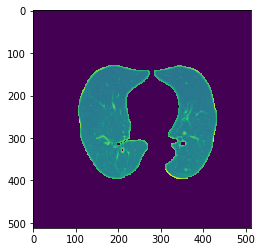

1.3.6.1.4.1.14519.5.2.1.6279.6001.188376349804761988217597754952.mhd is done
1.3.6.1.4.1.14519.5.2.1.6279.6001.146429221666426688999739595820.mhd is processing
Kmeans is doing its thing
Kmeans is done


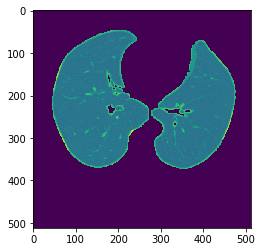

1.3.6.1.4.1.14519.5.2.1.6279.6001.146429221666426688999739595820.mhd is done
1.3.6.1.4.1.14519.5.2.1.6279.6001.187451715205085403623595258748.mhd is processing
Kmeans is doing its thing
Kmeans is done


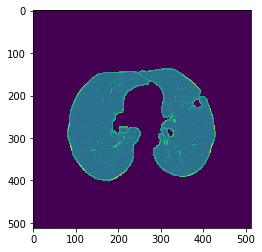

1.3.6.1.4.1.14519.5.2.1.6279.6001.187451715205085403623595258748.mhd is done
1.3.6.1.4.1.14519.5.2.1.6279.6001.154677396354641150280013275227.mhd is processing
Kmeans is doing its thing
Kmeans is done


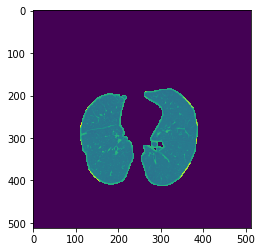

1.3.6.1.4.1.14519.5.2.1.6279.6001.154677396354641150280013275227.mhd is done
1.3.6.1.4.1.14519.5.2.1.6279.6001.141069661700670042960678408762.mhd is processing
Kmeans is doing its thing
Kmeans is done


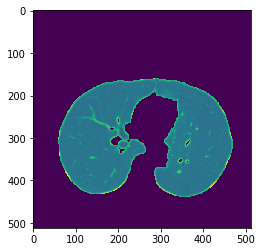

1.3.6.1.4.1.14519.5.2.1.6279.6001.141069661700670042960678408762.mhd is done
1.3.6.1.4.1.14519.5.2.1.6279.6001.144438612068946916340281098509.mhd is processing
Kmeans is doing its thing
Kmeans is done


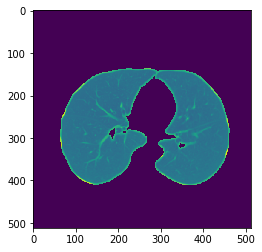

1.3.6.1.4.1.14519.5.2.1.6279.6001.144438612068946916340281098509.mhd is done
1.3.6.1.4.1.14519.5.2.1.6279.6001.188209889686363159853715266493.mhd is processing
Kmeans is doing its thing
Kmeans is done


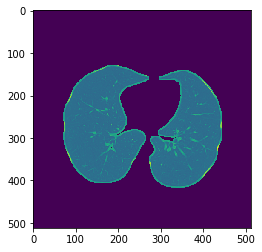

1.3.6.1.4.1.14519.5.2.1.6279.6001.188209889686363159853715266493.mhd is done


In [119]:
process_dir('/Users/kanetian7/LUNA16/data/subset0/2/', '/Users/kanetian7/LUNA16/data/processed0/')